[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-5-nano",
                 temperature = 0)

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [5]:
# class Analyst: name, role, affiliation, and description
from typing import List
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
    )
    
    name: str = Field(
        description="Name of the analyst."
    )
    
    role: str = Field(
        description="Role of the analyst in context of the topic."
    )
    
    description: str = Field(
        description="Description of the analyst's focus, concerns, and motives."
    )
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}"

# 1 Class for All Analysts: List[Analyst]

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description= "Comprehensive list of analysts with their names, roles, affiliations, and descriptions."
    )
    
# State for analyst: topic, max_analyts, human_feedback, and List[Analyst]
from typing_extensions import TypedDict

class GenerateAnalystsState(TypedDict):
    topic: str  # Research topic
    max_analysts: int # Number of analysts 
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    
    

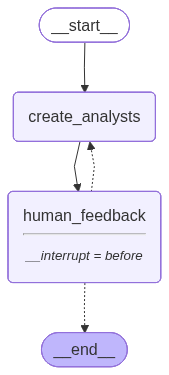

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """ You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and /or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.
"""

def create_analysts(state: GenerateAnalystsState):
    """ Create analysts"""
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')
    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)
    
    # System message
    system_message = analyst_instructions.format(topic = topic,
                                                 human_analyst_feedback = human_analyst_feedback,
                                                 max_analysts = max_analysts)
    # Generate qustion
    analysts = structured_llm.invoke([SystemMessage(content=system_message),
                                      HumanMessage(content="Generate the set of analysts.")
    ])

    
    # Write the list of analysis to the state
    # outer analysts = variable name from above
    # inner analysts = field name
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass
    

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """
    
    # Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # else end
    return END

# Nodes
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# Edges
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analysts", END])


memory = InMemorySaver()

graph = builder.compile(interrupt_before = ["human_feedback"],
                        checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# input
topic = "The benefits of adopting LangGraph as an agent framework"
max_analysts = 3
thread = {"configurable": {"thread_id": "1"}}

            
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Failed to multipart ingest runs: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


Name: Dr. Mei Chen
Affiliation: LangGraph Research Council
Role: Ecosystem & Interoperability Analyst
Description: Evaluates how LangGraph enables modular agent composition, cross-language interoperability, and a growing plugin ecosystem; assesses enterprise integration value, standardization benefits, and total cost of ownership.
--------------------------------------------------
Name: Omar Haddad
Affiliation: Independent AI Performance Lab
Role: Performance & Scalability Analyst
Description: Assesses runtime performance, resource efficiency, latency, throughput, fault tolerance, and scalability of LangGraph-based agents; benchmarks against alternatives and provides architectural guidance.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Center for Responsible AI
Role: Governance, Safety & Compliance Analyst
Description: Examines governance, safety, auditing, and regulatory considerations when adopting LangGraph; outlines risk management frameworks

In [8]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'analysts': [Analyst(affiliation='LangGraph Research Council', name='Dr. Mei Chen', role='Ecosystem & Interoperability Analyst', description='Evaluates how LangGraph enables modular agent composition, cross-language interoperability, and a growing plugin ecosystem; assesses enterprise integration value, standardization benefits, and total cost of ownership.'), Analyst(affiliation='Independent AI Performance Lab', name='Omar Haddad', role='Performance & Scalability Analyst', description='Assesses runtime performance, resource efficiency, latency, throughput, fault tolerance, and scalability of LangGraph-based agents; benchmarks against alternatives and provides architectural guidance.'), Analyst(affiliation='Center for Responsible AI', name='Sophia Martinez', role='Governance, Safety & Compliance Analyst', description='Examines governance, safety, auditing, and regulatory consid

In [9]:
state.next

('human_feedback',)

In [10]:
# updating the state as if we are the human_feedback node
graph.update_state(
    thread,
    {"human_analyst_feedback": "Add in someone from a startup to add an entreprenuer perspective"}, as_node = "human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e3537-da9e-6984-8002-2e44dbcb807b'}}

In [11]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Mei Chen
Affiliation: LangGraph Research Council
Role: Ecosystem & Interoperability Analyst
Description: Evaluates how LangGraph enables modular agent composition, cross-language interoperability, and a growing plugin ecosystem; assesses enterprise integration value, standardization benefits, and total cost of ownership.
--------------------------------------------------
Name: Omar Haddad
Affiliation: Independent AI Performance Lab
Role: Performance & Scalability Analyst
Description: Assesses runtime performance, resource efficiency, latency, throughput, fault tolerance, and scalability of LangGraph-based agents; benchmarks against alternatives and provides architectural guidance.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Center for Responsible AI
Role: Governance, Safety & Compliance Analyst
Description: Examines governance, safety, auditing, and regulatory considerations when adopting LangGraph; outlines risk management frameworks

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


Name: Dr. Amina Patel
Affiliation: LangGraph Labs, R&D
Role: Principal Architect and Research Lead
Description: Theme: Technical agility and scalability. Focuses on modular graph-based agent composition, interoperability with external toolchains, performance, scalability, and security in distributed agent graphs. Evaluates how LangGraph enables rapid architecture evolution, reuse of components, and predictable performance as agent graphs grow.
--------------------------------------------------
Name: Diego Romero
Affiliation: LangGraph Platform & Observability
Role: Director of Agent Orchestration
Description: Theme: Orchestration and governance of multi-agent systems. Specializes in cross-agent coordination, state management, debugging and tracing, policy enforcement, and reliability/safety. Assesses how LangGraph improves observability, governance, and controlled collaboration across heterogeneous agents.
--------------------------------------------------
Name: Maya Chen
Affiliation: 

In [12]:
# satisfied, so no further human feedback as input
further_feedback = None
graph.update_state(thread,
                   {"human_analyst_feedback": further_feedback}, as_node = "human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e3538-c8a3-6e9a-8004-a94806668b02'}}

In [13]:
# continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("=== NODE ===")
    node_name = next(iter(event.keys()))
    print(node_name)

In [14]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [15]:
final_state.next 
# confirm we're done

()

In [16]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Amina Patel
Affiliation: LangGraph Labs, R&D
Role: Principal Architect and Research Lead
Description: Theme: Technical agility and scalability. Focuses on modular graph-based agent composition, interoperability with external toolchains, performance, scalability, and security in distributed agent graphs. Evaluates how LangGraph enables rapid architecture evolution, reuse of components, and predictable performance as agent graphs grow.
--------------------------------------------------
Name: Diego Romero
Affiliation: LangGraph Platform & Observability
Role: Director of Agent Orchestration
Description: Theme: Orchestration and governance of multi-agent systems. Specializes in cross-agent coordination, state management, debugging and tracing, policy enforcement, and reliability/safety. Assesses how LangGraph improves observability, governance, and controlled collaboration across heterogeneous agents.
--------------------------------------------------
Name: Maya Chen
Affiliation: 

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [17]:
# Interview between each analyst and expert
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number of turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API
    
class SearchQuery(BaseModel):
    search_query: str = Field(None, description = "Search query for retrieval.")

In [18]:
question_instructions = """ You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic. 

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.

"""

def generate_question(state: InterviewState):
    """ Node to generate a question """
    
    # get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    # generate question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content = system_message)] + messages)
    
    # write messages to state
    return {"messages": [question]}
    

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [19]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [20]:
# Web search tool
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

/Users/koushalsmodi/Desktop/MachineLearning/MachineLearningProjects/LangGraph/lca-lc-foundations/.venv/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/Users/koushalsmodi/Desktop/MachineLearning/MachineLearningProjects/LangGraph/lca-lc-foundations/.venv/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [21]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [29]:
# search web and search wikipedia
from langchain_core.messages import get_buffer_string

# System message for high quality web search and searching wikipedia
search_instructions = SystemMessage(content = f""" You will be given a conversation between an analyst and an expert.
                                    
Your goal is to generate a well-structured query for use in retrival and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst. 

Convert this final question into a well-structured web search query           
                                    
""")

def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    
    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # search 
    # search docs = tavily_search.invoke(search_query.search_query)
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)   
    
    # format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc.get("url", "")}"/>\n{doc.get("content", doc)}\n</Document>'
            if isinstance(doc, dict)
            else f"<Document>\n{doc}\n</Document>"
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}
    
def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """
    
    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    
    # search wikipedia
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
    
    # format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}

answer_instructions = """ You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

Your goal is to answer a question posed by the interviewer.

To answer question, use this context:
{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources in your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama_3_1.pdf" page = "7"> then just list:

[1] assistant/docs/llama_3_1.pdf, page 7
And skip the addition of the brackets as well as the Document source preamble in your citation.
"""

def generate_answer(state: InterviewState):
    """ Node to answer a question """
    
    # get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    # answer question
    system_message = answer_instructions.format(goals = analyst.persona, context = context)
    answer = llm.invoke([SystemMessage(content = system_message)] + messages)
    
    answer.name = "expert"
    
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """ Save interviews """
    
    # get messages
    messages = state["messages"]
    
    # convert interview to a string
    interview = get_buffer_string(messages)
    
    # save to interviews key
    
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):
    """ Route between question (ask_question in other words: generate_question) and answer (answer_question in other words generate_answer) """
    
    # get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)
    
    # check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    
    # end if the expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"
    
    # this router is run after each question-answer pair
    # get the last question asked to check if it signals the end of discussion
    last_question= messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [30]:
def write_section(state: InterviewState):
    """ Node to write the report """
    
    # get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    # write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus = analyst.description)
    section = llm.invoke([SystemMessage(content = system_message)] + [HumanMessage(content = f"Use this source to write your section: {context}")])
    
    # append to the state
    return {"sections": [section.content]}
    
# Add nodes
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Edges
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question",
                                        route_messages,
                                        ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

memory = InMemorySaver()

interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interviews")

In [31]:
# Pick one analyst
analysts[0]

Analyst(affiliation='LangGraph Labs, R&D', name='Dr. Amina Patel', role='Principal Architect and Research Lead', description='Theme: Technical agility and scalability. Focuses on modular graph-based agent composition, interoperability with external toolchains, performance, scalability, and security in distributed agent graphs. Evaluates how LangGraph enables rapid architecture evolution, reuse of components, and predictable performance as agent graphs grow.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [32]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}

interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: lang

## LangGraph: Graph-based Agility and Scalability for Production-Grade AI Agents

### Summary
In modern AI agent ecosystems, organizations demand tools that support rapid architectural evolution, component reuse, interoperation with external toolchains, and predictable performance as agent graphs scale. LangGraph positions itself as the graph-based orchestration layer that complements LangChain by enabling stateful, multi-agent workflows with modular building blocks you can swap in or out as needed. A core aim has been to move LangGraph from a prototype or research tool to a production-grade runtime, addressing questions about when to use LangGraph versus other frameworks and what makes an agent fundamentally different from traditional software.

Key capabilities highlighted across the sources include: a graph-based memory model that supports multi-agent coordination, tool use interoperability, and streaming outputs (including LLM token streams) to power polished user interfaces and real-time monitoring; customizable message types and parameters; robust function-calling quality and state/LLM token management; and the ability to interrupt or resume for human-in-the-loop scenarios simply by invoking an interrupt() in a node. This modular approach—providing six building blocks as interchangeable components—gives developers the freedom to compose, evolve, and reuse parts of their agent logic without rewrites, which is central to rapid architecture evolution and scalable performance as graphs grow.

Several posts emphasize the extensibility and production-readiness of LangGraph: its visual workflow management and support for decision trees with real conditional branching enable non-linear, stateful agent behavior beyond traditional linear pipelines; native/strong integration with existing toolchains (including the broader LangChain ecosystem) accelerates adoption in production environments; and a companion visual IDE and documented patterns help teams scale workflows from prototype to deployment. The broader discussion around LangGraph also highlights practical patterns—routing, parallel execution, memory, and looped feedback—that support complex, reliable agent systems, including cross-tool interactions and real-time human-in-the-loop interactions. Taken together, the insights underscore LangGraph’s promise for predictable performance, component reuse, and agile evolution in distributed agent graphs, while signaling practical considerations around visualization, tooling, and integration in enterprise contexts.

1. LangGraph blog post on building LangGraph and its design goals for production-ready agents.  
2. Community discussion comparing LangGraph’s advantages, including visual workflows and branching decision trees.  
3. Medium overview of why LangGraph stands out as an exceptional agent framework, including streaming outputs and customizable message management.  
4. Medium patterns article detailing a LangGraph-based design with orchestrated nodes, streaming, and memory considerations.  
5. ScalablePath overview of LangGraph and LangChain’s role in agentic automation and production-readiness.  
6. YouTube discussion on the context and ambitions of building scalable, context-rich LLM apps with LangGraph.  

### Sources
[1] https://blog.langchain.com/building-langgraph/  
[2] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[3] https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6  
[4] https://medium.com/@sathishkraju/from-sketch-to-system-agentic-design-patterns-using-langgraph-my-take-e0088a91569b  
[5] https://www.scalablepath.com/machine-learning/langgraph  
[6] https://www.youtube.com/watch?v=95XrWA6-UFM

### Parallelize interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [46]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final repot
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report:str # Final report

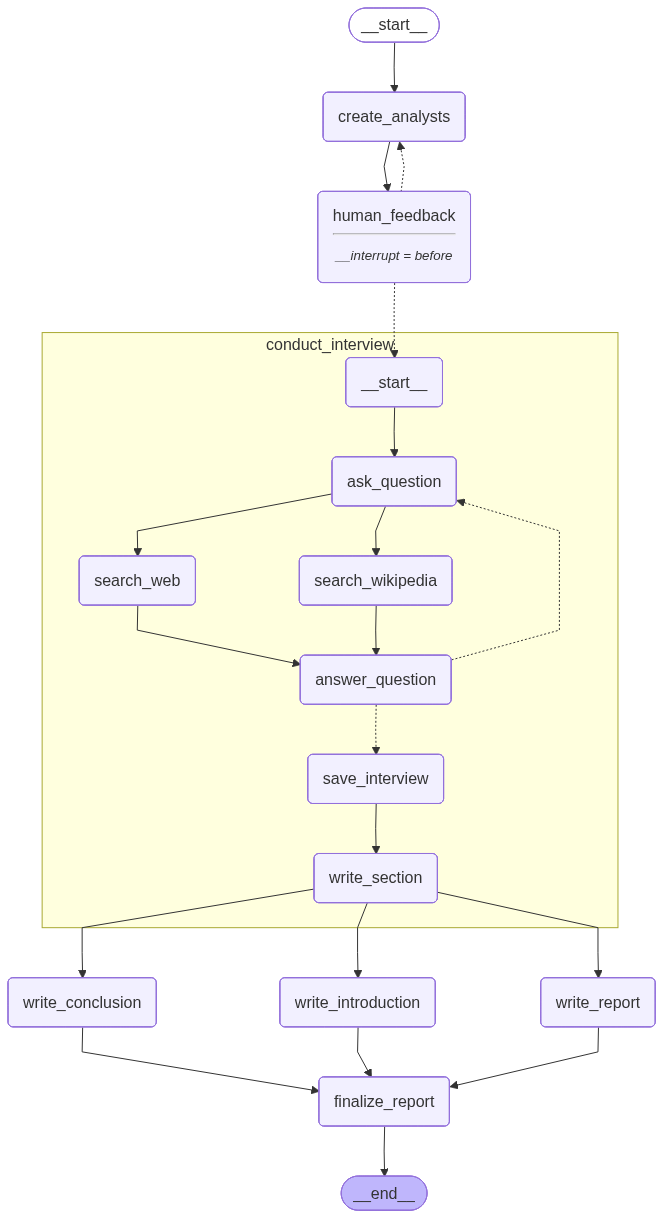

In [47]:
from langgraph.types import Send 
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" setep where we run each interview sub-graph using Send API """
    
    # check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback')
    
    if human_analyst_feedback:
        # return to create_analysts
        return "create_analysts"
    
    else:
        # kick off interviews in parallel via Send() API
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content= f"So you said you were writing an article on {topic}?"
                                           )
                                                        ]}) for analyst in state["analysts"]]



report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""


def write_report(state: ResearchGraphState):
    
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]
    
    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # summarize the sections into a final report
    system_message = report_writer_instructions.format(topic = topic, context = formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content = f"Write a report based upon these memos.")])
    
    return {"content": report.content}
    
intro_conclusion_instructions = """ You are a tehnical writer finishing a report on {topic}

You will be given all of the sections of the report.

Your job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}
"""

def write_introduction(state: ResearchGraphState):
    
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]
    
    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic = topic, formatted_str_sections = formatted_str_sections)
    intro = llm.invoke([instructions] + [HumanMessage(content = f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]
    
    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic = topic, formatted_str_sections = formatted_str_sections)
    conclusion = llm.invoke([instructions] + [HumanMessage(content = f"Write the report conclusion")])
    return {"conclusion": conclusion.content}
    

def finalize_report(state: ResearchGraphState):
    """ This is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    
    # save the full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None
        
    final_report = state["introduction"] + "\n\n---\n" + content + "\n\n---\n\n" + state["conclusion"]
    
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# nodes
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# edges
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")  
builder.add_edge(["write_conclusion", "write_introduction", "write_report"], "finalize_report")
builder.add_edge("finalize_report", END) 

# compile
memory = InMemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"],
                        checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [48]:
# inputs

topic = "The benefits of adopting LangGraph as an agent framework"
max_analysts = 3
thread = {"configurable": {"thread_id": "1"}}

# run the graph until the first interruption
for event in graph.stream({"topic": topic,
                           "max_analysts": max_analysts},
                          thread,
                          stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("=" * 60)

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


Name: Dr. Mira Chen
Affiliation: LangGraph Research Lab
Role: Systems Architect / Framework Integrator
Description: Focuses on LangGraph's architectural benefits, modularity, interoperability with existing AI stacks, and how graph-based reasoning and cross-domain agent coordination enable scalable, maintainable deployments. Considers performance, stability, standards, and potential integration challenges.
Name: Carlos Ruiz
Affiliation: OpenLang Foundation
Role: Developer Experience Engineer / Tooling Advocate
Description: Assesses developer experience, tooling, documentation, onboarding, debugging, and productivity gains from LangGraph. Advocates for a smooth learning curve, robust testing, and ecosystem maturity to accelerate adoption.
Name: Priya Kapoor
Affiliation: CloudSphere Partners
Role: Enterprise AI Strategy Consultant
Description: Evaluates business value, ROI, total cost of ownership, governance, risk, security, and compliance when adopting LangGraph at scale. Aligns LangGra

In [49]:
# we now update the state as if we are the human_feedback node
graph.update_state(thread,
                   {"human_analyst_feedback": "Add in the CEO of GenAI native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e35f8-0a7c-626c-8002-b6aee75ff4f3'}}

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


In [44]:
# check
for event in graph.stream({"topic": topic,
                           "max_analysts": max_analysts},
                          thread,
                          stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("=" * 60)

Name: Dr. Mira Kapoor
Affiliation: LangGraph Research Labs
Role: Architectural and Systems Design Analyst
Description: Focusing on modularity, composability, and orchestration of agents within LangGraph. Evaluates how graph-based topologies enable scalable, interoperable workflows and dynamic planning, while considering trade-offs in complexity and maintenance.
Name: Lucas Nguyen
Affiliation: TechStrategy Advisory
Role: Developer Experience and Ecosystem Analyst
Description: Assesses developer productivity, tooling, templates, DSLs, debugging, testing, and ecosystem growth. Identifies adoption barriers and outlines paths to a thriving LangGraph developer community and seamless integration into existing toolchains.
Name: Prof. Sofia Martins
Affiliation: Center for AI Governance and Safety
Role: Safety, Governance, and Reliability Analyst
Description: Examines safety controls, explainability, auditability, policy enforcement, and risk management. Ensures LangGraph adoption aligns with go

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


Name: Avery Chen
Affiliation: GenAIon Labs (GenAI-native startup)
Role: CEO
Description: Theme: Startup adoption and business value of LangGraph for GenAI-native startups. Avery Chen analyzes how LangGraph accelerates product development, enables rapid experimentation with multi-agent workflows, and delivers go-to-market advantages through scalable, privacy-conscious agent orchestration.
Name: Dr. Maya Singh
Affiliation: LangGraph Foundation
Role: Principal Systems Scientist
Description: Theme: Technical architecture and developer productivity with LangGraph. Maya assesses LangGraph’s graph-based agent orchestration, modularity, interoperability, and impact on developer velocity, reliability, and scalability.
Name: Liam O'Reilly
Affiliation: Enterprise AI Risk & Compliance Council
Role: Head of Governance & AI Risk
Description: Theme: Governance, safety, and risk management. Liam focuses on data provenance, auditability, safety controls, regulatory compliance, and risk mitigation when 

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


In [50]:
# confirm we are happy
graph.update_state(thread,
                   {"human_analyst_feedback": None}, as_node = "human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e35f8-6b75-66fe-8003-66f2a54a4838'}}

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


In [51]:
# continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("===NODE===")
    node_name = next(iter(event.keys()))
    print(node_name)

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: lang

===NODE===
conduct_interview
===NODE===
conduct_interview


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


===NODE===
conduct_interview


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


===NODE===
write_conclusion


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


===NODE===
write_introduction


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


===NODE===
write_report
===NODE===
finalize_report


In [52]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get("final_report")
Markdown(report)

# LangGraph: From Prototype to Production-Grade Agent Orchestration

## Introduction

LangGraph blends a visual, low-code graph surface with six modular blocks to design, deploy, and scale AI agent workflows. The first section surveys graph-driven modularity, cross-domain coordination, and production-ready reliability, highlighting how reusable blocks enable dynamic routing, state machines, and seamless LangChain integration. The second section emphasizes developer-centric tooling—onboarding, streaming outputs, observability, and debugging—delivering a low-friction path from prototype to production. The third section assesses ROI and governance—TCO considerations, security, and enterprise alignment—demonstrating how LangGraph supports scalable, auditable agent ecosystems while balancing control and speed.

---


LangGraph represents a production-grade, graph-driven extension of LangChain that translates LLM integration into a scalable, maintainable agent fabric designed for real-world workflows. Its core value proposition centers on modularity: six interchangeable building blocks form a spectrum of capabilities, allowing teams to select only the components they need and to plug in or remove features such as human-in-the-loop interruptions without wholesale rewrites [1]. The graph-based design surface enables cross-domain coordination and dynamic routing via routers and state-machine patterns, while preserving compatibility with existing AI stacks through LangChain’s LLM backend, helping teams adopt the framework without abandoning their current tooling [1].

From a developer experience perspective, LangGraph is positioned as a production-focused, developer-friendly framework that emphasizes onboarding simplicity and long-term maintainability. The platform supports a low-code, visual pathway to design, test, and maintain intricate agent orchestrations, with real-time visibility into reasoning paths and outcomes. Features such as streaming node outputs (including LLM tokens) and UI-friendly representations of explanations and results address common onboarding and debugging hurdles, enabling teams to iterate quickly without rewrites [2]. True conditional branching in decision trees and robust workflow control further reduce the friction of translating complex logic into maintainable graphs, which is cited as a key advantage for production readiness and observable workflows [3].

LangGraph’s production-grade orientation extends into governance, observability, and ecosystem fit. The architecture emphasizes type safety and a Pydantic-based stack to manage data contracts and reliability, aligning with enterprise expectations for auditable, Governable AI workflows [2]. Business value in production contexts emerges when organizations map specific enterprise needs to LangGraph’s strengths—particularly observability, modularity, and scalable multi-agent coordination—rather than assuming a one-size-fits-all solution; ROI and total cost of ownership depend on disciplined use-case definition and integration with existing data systems and security requirements [3]. Notably, LangGraph is framed as a mature ecosystem that complements LangChain tooling, reinforcing a pragmatic path to scale through established tooling and integration patterns rather than forcing a single monolithic approach [4][5].

In practice, the benefits of adopting LangGraph include accelerated onboarding, clearer deployment boundaries, and the ability to upgrade agent architectures incrementally through its building blocks, all while maintaining production-grade reliability. The platform supports advanced debugging, observability, and streaming interaction models that improve developer speed and user experience in real-world deployments, aligning with enterprise expectations for scalable, auditable workflows across multi-actor environments [2][3]. While challenges such as mapping legacy toolchains to a graph-based design and ensuring performance at scale require careful planning, the overall narrative across industry analyses and practitioner discussions is that LangGraph offers a compelling balance of developer ergonomics, operational rigor, and cross-domain orchestration for production-ready AI workflows [1].


---

## Conclusion

LangGraph delivers production-grade agent orchestration by combining graph-driven modularity with LangChain’s LLM backbone. Across the sections, six interchangeable building blocks enable cross-domain workflows with observability, clear deployment boundaries, and scalable reasoning. Developer-centric tooling accelerates onboarding, debugging, and explainability through visual workflow management and streaming outputs, without enforcing a monolithic approach. At scale, LangGraph supports ROI and governance through robust observability, type safety, and enterprise alignment, balancing speed to value with security and compliance. Together, these capabilities transform experimental agent research into reliable, scalable production workflows that meet real-world business needs.

## Sources

https://blog.langchain.com/building-langgraph/  
https://www.langchain.com/langgraph  
https://oxylabs.io/blog/langgraph-vs-langchain  
https://www.curotec.com/insights/langchain-vs-langgraph-framework-comparison/  
https://www.reddit.com/r/LangChain/comments/1g1pkki/openais_new_framework_for_agents_why_is_langgraph/  
https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6  
https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
https://www.youtube.com/watch?v=1w5cCXlh7JQ  
https://medium.com/@hieutrantrung.it/the-ai-agent-framework-landscape-in-2025-what-changed-and-what-matters-3cd9b07ef2c3  
https://softcery.com/lab/top-14-ai-agent-frameworks-of-2025-a-founders-guide-to-building-smarter-systems  
https://www.turing.com/resources/ai-agent-framework

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
